# Season Preview Video

# Topic 1: Opening Races
- Australia vs Bahrain (first time since 2019)
  - How does this impact conditions?
  - Tyre Deg focus
- The Red Bull Switch Up
  - What should we expect from our new drivers
  - Look at Isaac Hadjar
- Big dog at back team
  - What should Carlos expect?
  - Compare driver styles between Sargaent, Albon, and Carlos



# Utilities

In [10]:
library(tidyverse)
library(httr2)
library(jsonlite)
library(data.table)
library(fuzzyjoin)
library(cowplot)
library(tidyr)
library(ggdag)

tyre_color_scheme = c("SOFT" = "red", "MEDIUM" = "yellow", "HARD" = "grey")

filter_outliers_iqr <- function(data, column, factor = 1.5) {
  Q1 <- quantile(data[[column]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data[[column]], 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - factor * IQR
  upper_bound <- Q3 + factor * IQR
  
  data %>%
    filter(data[[column]] >= lower_bound & data[[column]] <= upper_bound)
}

get_tyre_deg_data = function (df, iqr_factor = 1.5) {
  df %>% 
    filter_outliers_iqr(column = "lap_duration", factor = iqr_factor) %>% 
    filter(!is_pit_out_lap) %>% 
    select(driver_number.x, compound, tyre_age_at_start, lap_number, lap_start, lap_duration, stint_number) %>% 
    mutate(tyre_age = tyre_age_at_start + lap_number - lap_start)
}

get_lap_data = function(session_id, driver_number) {
  request(paste0("https://api.openf1.org/v1/laps?session_key=", session_id, "&driver_number=", driver_number)) %>% 
    req_perform() %>% 
    resp_body_json() 
}

get_stint_data = function(session_id, driver_number) {
  request(paste0("https://api.openf1.org/v1/stints?session_key=", session_id, "&driver_number=", driver_number)) %>% 
    req_perform() %>% 
    resp_body_json()
}

get_sessions_data = function(year) {
  request(paste0("https://api.openf1.org/v1/sessions?year=", year)) %>% 
    req_perform() %>% 
    resp_body_json() %>% 
    bind_rows()
}

theme_dracula = function() {
  theme(
    plot.background = element_rect("#282A36"),
    panel.background = element_rect("#282A36"),
    panel.grid = element_blank(),
    axis.title = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
  )
}


Attaching package: ‘ggdag’

The following object is masked from ‘package:stats’:

    filter



Warning message:
package ‘ggdag’ was built under R version 4.3.3 


# Get Session Data

In [2]:
response = get_sessions_data(2024)

bahrain_race_session = response %>% 
  filter(session_name == "Race", country_name == "Bahrain") %>% 
  pluck("session_key")

australia_race_session = response %>% 
  filter(session_name == "Race", country_name == "Australia") %>% 
  pluck("session_key")

driver_number = 63 

# Australia vs Bahrain

## Overview
- Noticable differences between the two tracks
- Focus on tyre degredation between the two tracks

## Get Lap Data for Each Race

In [3]:
bahrain_race_data = get_lap_data(bahrain_race_session, driver_number)
bahrain_stint_data = get_stint_data(bahrain_race_session, driver_number)

australia_race_data = get_lap_data(australia_race_session, driver_number)
australia_stint_data = get_stint_data(australia_race_session, driver_number)

In [4]:
tyre_deg_data_cols = c("driver_number", "date_start", "lap_duration", "is_pit_out_lap", "lap_number")
stint_data_cols = c("stint_number", "compound", "lap_start", "lap_end", "tyre_age")

get_tyre_deg_cols = function (x) {x[tyre_deg_data_cols]}

bahrain_tyre_deg = map(bahrain_race_data, get_tyre_deg_cols) %>% 
  bind_rows()

bahrain_stint_63 = bahrain_stint_data %>% bind_rows()

joined_data_bahrain_63 = fuzzyjoin::fuzzy_inner_join(
  bahrain_tyre_deg,
  bahrain_stint_63,
  by = c("lap_number" = "lap_start", "lap_number" = "lap_end"),
  match_fun = list(`>=`, `<=`)
)

australia_tyre_deg = map(australia_race_data, get_tyre_deg_cols) %>% 
  bind_rows()

australia_stint_63 = australia_stint_data %>% bind_rows()

joined_data_australia_63 = fuzzyjoin::fuzzy_inner_join(
  australia_tyre_deg,
  australia_stint_63,
  by = c("lap_number" = "lap_start", "lap_number" = "lap_end"),
  match_fun = list(`>=`, `<=`) 
)

## Bahrain Tyre Deg Data

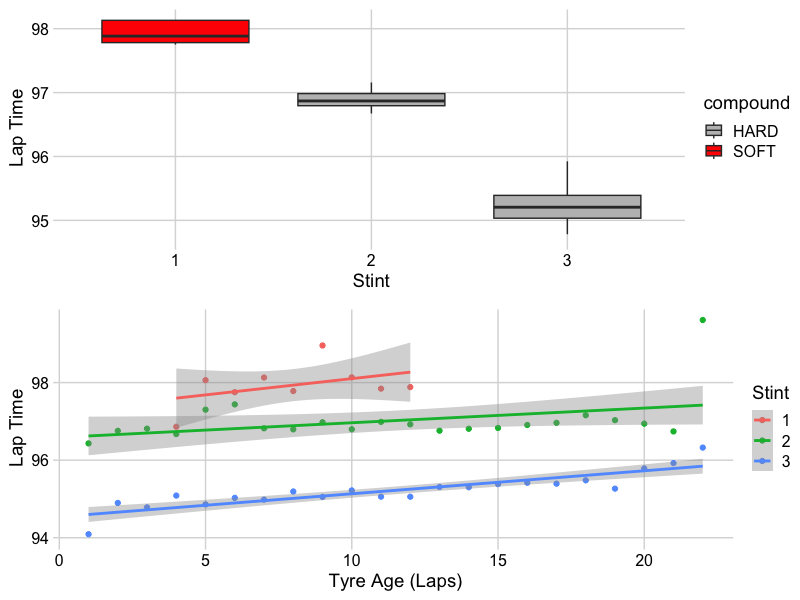

In [5]:
plot_data_63_bahrain = joined_data_bahrain_63 %>% 
  get_tyre_deg_data()


stint_graph = plot_data_63_bahrain %>% 
  ggplot() +
    geom_boxplot(mapping = aes(x = as.factor(stint_number), y = lap_duration, fill = compound), outliers = FALSE) +
    scale_fill_manual(values = tyre_color_scheme) +
    theme_minimal_grid() +
    xlab("Stint") +
    ylab("Lap Time")

tyre_stint_graph = plot_data_63_bahrain %>%
  ggplot() +
    geom_point(mapping = aes(x = tyre_age, y = lap_duration, color = as.factor(stint_number))) +
    geom_smooth(mapping = aes(x = tyre_age, y = lap_duration, color = as.factor(stint_number)), method = lm, formula = y ~ poly(x, 1)) +
    theme_minimal_grid() +
    xlab("Tyre Age (Laps)") +
    ylab("Lap Time") +
    guides(color=guide_legend(title="Stint"))

bah_plot_graphs = plot_grid(stint_graph, tyre_stint_graph,  nrow = 2)

bah_plot_graphs

## Australia Tyre Deg Data

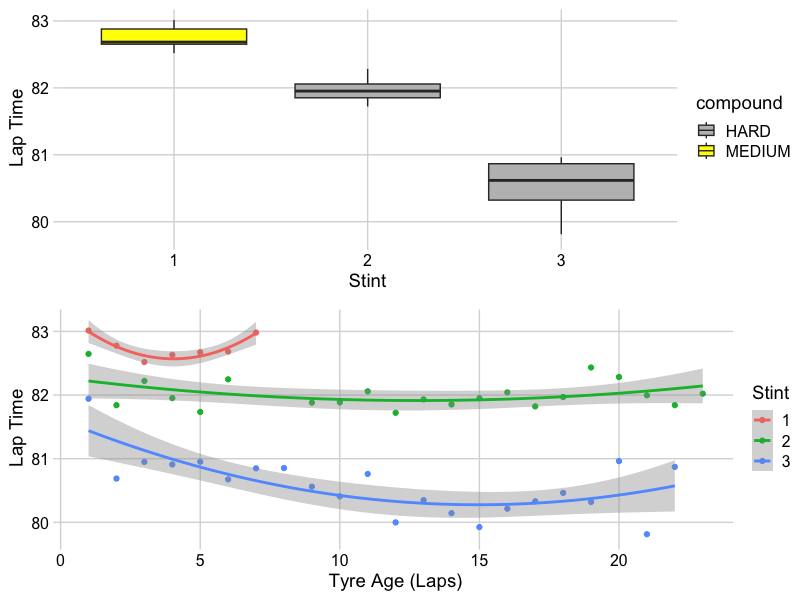

In [6]:
plot_data_63_aus= joined_data_australia_63 %>% 
  get_tyre_deg_data()


stint_graph = plot_data_63_aus %>% 
  ggplot() +
    geom_boxplot(mapping = aes(x = as.factor(stint_number), y = lap_duration, fill = compound), outliers = FALSE) +
    scale_fill_manual(values = tyre_color_scheme) +
    theme_minimal_grid() +
    xlab("Stint") +
    ylab("Lap Time")

tyre_stint_graph = plot_data_63_aus %>%
  ggplot() +
    geom_point(mapping = aes(x = tyre_age, y = lap_duration, color = as.factor(stint_number))) +
    geom_smooth(mapping = aes(x = tyre_age, y = lap_duration, color = as.factor(stint_number)), method = lm, formula = y ~ poly(x, 2)) +
    theme_minimal_grid() +
    xlab("Tyre Age (Laps)") +
    ylab("Lap Time") +
    guides(color=guide_legend(title="Stint"))

aus_plot_graphs = plot_grid(stint_graph, tyre_stint_graph,  nrow = 2)

aus_plot_graphs

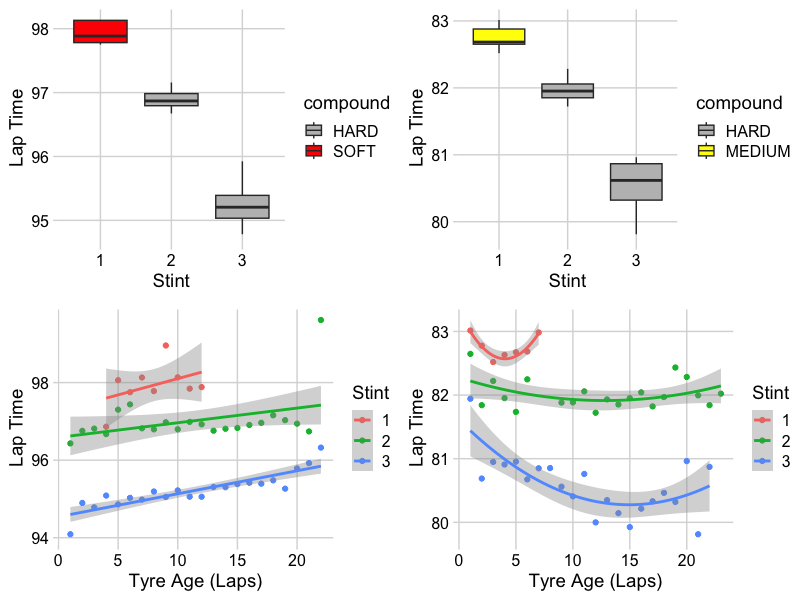

In [7]:
plot_grid(bah_plot_graphs, aus_plot_graphs, ncol = 2)

In [8]:
tyre_deg_models_bah = plot_data_63_bahrain %>% 
  group_by(stint_number) %>% 
  do(model = lm(lap_duration ~ tyre_age, data = .)) %>%  
  mutate(
    intercept = coef(model)[1],
    slope = coef(model)[2],
    error = summary(model)$r.squared
  ) %>% 
  select(-model)

tyre_deg_models_aus = plot_data_63_aus %>% 
  group_by(stint_number) %>% 
  do(model = lm(lap_duration ~ tyre_age + I(tyre_age)^2, data = .)) %>% 
  mutate(
    intercept = coef(model)[1],
    slope = coef(model)[2],
    error = summary(model)$r.squared
  )

poly1d_fit = summary(lm(formula = lap_duration ~ poly(tyre_age, 1), data = plot_data_63_bahrain %>% filter(stint_number == 3)))
poly2d_fit = summary(lm(formula = lap_duration ~ poly(tyre_age, 2), data = plot_data_63_bahrain %>% filter(stint_number == 3)))

print(poly1d_fit)
print(poly2d_fit)


Call:
lm(formula = lap_duration ~ poly(tyre_age, 1), data = plot_data_63_bahrain %>% 
    filter(stint_number == 3))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5095 -0.1134  0.0096  0.1207  0.4793 

Coefficients:
                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       95.22214    0.04759 2001.011  < 2e-16 ***
poly(tyre_age, 1)  1.76442    0.22320    7.905  1.4e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2232 on 20 degrees of freedom
Multiple R-squared:  0.7575,	Adjusted R-squared:  0.7454 
F-statistic: 62.49 on 1 and 20 DF,  p-value: 1.401e-07


Call:
lm(formula = lap_duration ~ poly(tyre_age, 2), data = plot_data_63_bahrain %>% 
    filter(stint_number == 3))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58250 -0.08213  0.02285  0.11642  0.40633 

Coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)        95.22214    0.04806 1981.179  < 2e-16

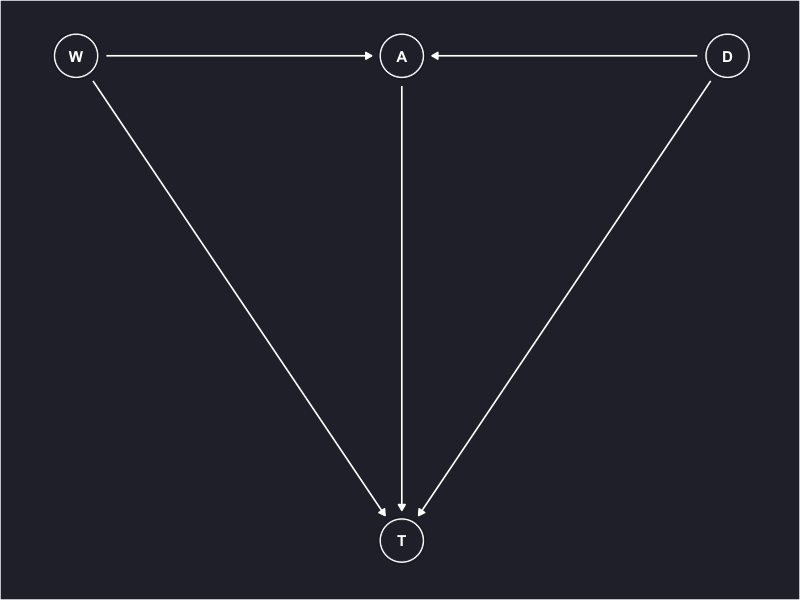

In [20]:
fox_dag = ggdag::dagify(
  T ~ A,
  A ~ W,
  T ~ W,
  T ~ D,
  A ~ D,
  coords = list(
    x = c(A = 0, T = 0, D = 1, W = -1),
    y = c(A = 0, T = -1, D = 0, W = 0)
  )
) 

ggdag(fox_dag) +
  geom_dag_edges(edge_colour = "#ffffff") +
  geom_dag_node(colour = "#282A36") +
  geom_dag_text(colour = "#ffffff") + 
  theme_dracula()